![](https://elnacionaldigital.com/wp-content/uploads/2019/12/Inteligencia-artificial.png)

#<center> **Clasificación de Géneros Musicales**

####Wilder Steven Rojas Prada - 2151857
####David Santiago Castro Martínez - 2160068

# ***Importación de las librerias necesarias***

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/ProyectoIA
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ProyectoIA
/content/drive/My Drive/ProyectoIA


In [0]:
import os
import csv
import sys
import librosa
import pathlib
import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import librosa.display as dis
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras

### **Si no ha instalado librosa ejecute este comando**

In [3]:
!pip install librosa

# ***Manejo de audio individualmente***

### **Dimensiones de un audio**

In [4]:
wav, sr = librosa.load('./data/1_piano_1.wav', sr=None) #carga un archivo de audio según la ruta especificada, además de la frecuencia original
print(type(sr),type(wav))
print ('sr:', sr)
print ('wav shape:', wav.shape)

<class 'int'> <class 'numpy.ndarray'>
sr: 48000
wav shape: (686400,)


### **Reproducción del audio**

In [5]:
ipd.Audio('./data/1_piano_1.wav') #carga y reproduce el archivo de sonido según la ruta especificada

Output hidden; open in https://colab.research.google.com to view.

### **Grafica del audio en un espectro plano**

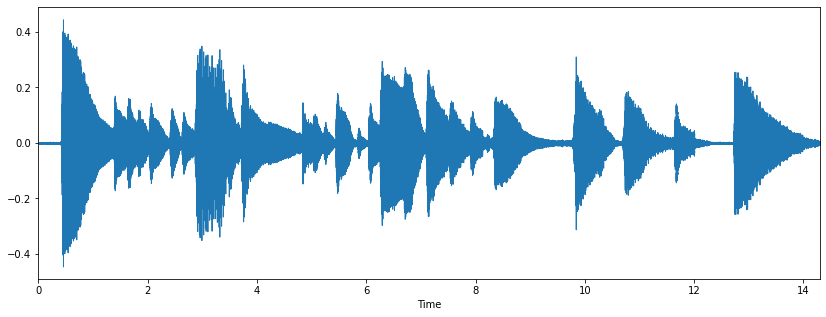

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(wav, sr=sr);      #mapea el comportamiento del audio en escala del tiempo en segundos
#plt.plot(wav);                             #mapea el comportamiento del audio en escala del tiempo en microsegundos

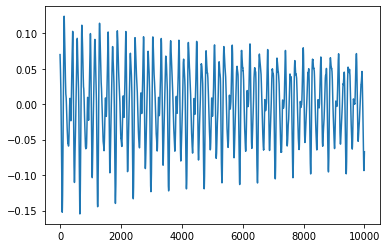

In [7]:
plt.plot(wav[50000:60000])    #mapea en un rango especifico de tiempo

### **Espectrograma del audio redimensionado**

(1025, 1341)
(1374525,)


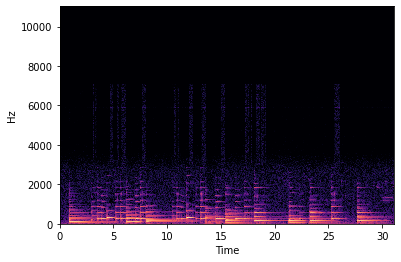

In [8]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max) #convierte una escala de espectrograma en una escala de dB
print (D.shape)
print (D.reshape(D.shape[0]*D.shape[1]).shape)   #redimensiona la matriz en un vector
dis.specshow(D, x_axis='time', y_axis='linear'); #grafica el espectograma

# ***Espectrogramas a partir del dataset. Creación de los directorios y agregación de los espectrogramas correspondientes a cada clase***

In [9]:
#Toma la gama de colores de preferencia para graficar
cmap = plt.get_cmap('inferno')

#Establece el marco donde se grafica en un tamaño de 10x10
plt.figure(figsize=(10,10)) 

#Establece un arreglo con cada cadena de caracteres separados por espacio
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split() 

#Toma cada item de la lista como un índice para el ciclo iterativo
for g in genres:

    #crea una carpeta nombre del item de la lista referenciada y además evita que se genere carpetas con nombres repetidos en una ruta padre especificada
    pathlib.Path(f'./data/img_data/{g}').mkdir(parents=True, exist_ok=True)

    #Toma los nombres del listado de elementos ubicados en una ruta especificada y genera otra lista como índice para el ciclo iterativo
    for filename in os.listdir(f'./data/genres/{g}'): 

        #Nombra el archivo a generar con el nombre de la ruta padre seguido con el mismo nombre del archivo de las carpetas especificadas anteriormente
        songname = f'./data/genres/{g}/{filename}'

        #Carga el archivo y asigna el nombre establecido en la linea anterior
        y, sr = librosa.load(songname, mono=True, duration=6)

        #Genera la gráfica del espectograma con base al array generado en la linea anterior
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');

        #Elimina las etiquetas de los ejes
        plt.axis('off');

        #Guarda la figura en una imagen formato png
        plt.savefig(f'./data/img_data/{g}/{filename[:-3].replace(".", "")}.png')

        #Limpia la figura para pintar otra sobre ese marco
        plt.clf()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 720x720 with 0 Axes>

# ***Trasformación del dataset en un dataset de espectrogramas***

In [0]:
#Establece un arreglo de caracteres con una cantidad finita de caracteres
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

#Genera un arreglo de indices en el rango de 1 a 21
for i in range(1, 21):

    #Agrega mas porciones de caracteres con el valor del índice correspondiente
    header += f' mfcc{i}'

#Agrega un elemento llamado "label" al final del arreglo de caracteres creado al inicio
header += ' label'

#Convierte el arreglo de caracteres en una lista donde cada elemento es diferenciado al existir un espacio
header = header.split()

In [0]:
#Abre un nuevo archivo en el cual se puede editar
file = open('data.csv', 'w', newline='')
with file:
    #Coloca en formato csv el nuevo archivo
    writer = csv.writer(file)
    #Escribe una primera fila con los valores del arreglo generado en la celda anterior
    writer.writerow(header)

#Crea una lista a partir de un arreglo de caracteres
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

#Genera una lista de indice con base a los elementos creados en la lista creada anteriormente creada
for g in genres:

    #Toma los nombres del listado de elementos ubicados en una ruta especificada y genera otra lista como índice para el ciclo iterativo
    for filename in os.listdir(f'./data/genres/{g}'):

        #Nombra el archivo a generar con el nombre de la ruta padre seguido con el mismo nombre del archivo de las carpetas especificadas anteriormente
        songname = f'./data/genres/{g}/{filename}'

        #Carga el archivo y asigna el nombre establecido en la linea anterior
        y, sr = librosa.load(songname, mono=True, duration=30)

        #Calcula valores de interes en el espectograma
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)

        #Almacena en la variable un arreglo compuesto por las medias de los valores encontrados en forma de texto
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'

        #Genera una list de indices con base al valor de mfcc    
        for e in mfcc:
            #Agrega mas cadena de texto al arreglo con el valor de la media del valor encontrado anteriormente
            to_append += f' {np.mean(e)}'
        #Agrega al final de la misma cadena de texto otra parte con el texto de la lista creada al inicio del ciclo iterativo superior
        to_append += f' {g}'

        #Abre el archivo para hacer adiciones
        file = open('data.csv', 'a', newline='')
        with file:

            #Agrega una fila convirtiendo primero el arreglo de caracteres en una lista
            writer = csv.writer(file)
            writer.writerow(to_append.split())

# ***Datos:***

In [5]:
#Cargamos el dataset
musica = pd.read_csv("./data/data.csv")
print ("dimension de los datos", musica.shape)
musica.head()


dimension de los datos (1000, 30)


,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334008,-46.809993,40.932634,-21.463776,24.816275,-18.945571,15.253459,-15.050104,12.262823,-15.234050,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,136.170239,3.289490,48.931193,8.699106,13.954752,5.359449,0.381334,-13.490265,16.871769,5.145258,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,110.843070,18.620984,30.922996,3.291330,22.587447,-20.418303,12.120995,-26.347956,-4.356270,-26.406674,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,-15.438986,60.986727,0.725807,12.437828,1.183836,-1.540779,-17.888154,8.358496,-2.452068,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,102.829023,-12.517677,56.993472,2.271347,26.591402,-4.274803,17.338809,-7.985593,15.235427,-6.934599,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


# ***Ajuste y entrenamiento de datos:***

In [6]:
#Guardamos la columna de caracteristicas en el array labels
labels = musica.values[:, -1]
print(np.unique(labels), labels.shape)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock'] (1000,)


In [7]:
#Se codifican las caracteristicas, para pasarlas de string a una etiqueta númerica
codificar = preprocessing.LabelEncoder()
#Obtenemos a y
y = codificar.fit_transform(labels)#se obtienen los labels 
print(y.shape,np.unique(y))

(1000,) [0 1 2 3 4 5 6 7 8 9]


In [0]:
#Escogemos nuestra X
X=musica.values[:,1:-1]

#Dividir los datos para entrenamiento y para test
X= X.astype('float32')
y = y.astype('float32')

In [0]:
#Aplicando PCA
D=PCA(n_components=28).fit_transform(X)
X_tr, X_t, y_tr, y_t = train_test_split(D, y, test_size=0.2)

# ***GaussianNB***

In [10]:
#Gaussian Naive Bayes
est = GaussianNB()

s = cross_val_score(est, D, y, cv=KFold(100, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.552 (+/- 0.15458)


In [11]:
est.fit(X_tr, y_tr)

print ("TRAIN accuracy %.3f"%est.score(X_tr, y_tr))
print ("TEST  accuracy %.3f"%est.score(X_t, y_t))

TRAIN accuracy 0.649
TEST  accuracy 0.550


# ***DecisionTreeClassifier (DTC)***

In [12]:
est = DecisionTreeClassifier( max_depth= 50)

s = cross_val_score(est, D, y, cv=KFold(100, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.428 (+/- 0.15432)


In [13]:
est.fit(X_tr, y_tr)

print ("TRAIN accuracy %.3f"%est.score(X_tr, y_tr))
print ("TEST  accuracy %.3f"%est.score(X_t, y_t))

TRAIN accuracy 0.999
TEST  accuracy 0.455


# ***SuperVectorMachine (SVM)***

In [14]:
est = SVC(kernel='poly')

s = cross_val_score(est, D, y, cv=KFold(30, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.292 (+/- 0.06298)


In [15]:
est.fit(X_tr, y_tr)

print ("TRAIN accuracy %.3f"%est.score(X_tr, y_tr))
print ("TEST  accuracy %.3f"%est.score(X_t, y_t))

TRAIN accuracy 0.287
TEST  accuracy 0.275


# ***RandomForestClassifier (RFC)***

In [16]:
est = RandomForestClassifier(n_estimators=100)

s = cross_val_score(est, D, y, cv=KFold(100, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.659 (+/- 0.14771)


In [17]:
est.fit(X_tr, y_tr)

print ("TRAIN accuracy %.3f"%est.score(X_tr, y_tr))
print ("TEST  accuracy %.3f"%est.score(X_t, y_t))

TRAIN accuracy 0.999
TEST  accuracy 0.685


# ***DeepLearning (DNN)***

In [18]:
#Creando la DNN
model = keras.models.Sequential([
    keras.layers.Flatten( input_shape=(X_tr.shape[1],)),
    keras.layers.Dense(26, activation=tf.nn.relu),
    keras.layers.Dense(24, activation=tf.nn.relu),
    keras.layers.Dense(22, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(18, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(14, activation=tf.nn.relu),
    keras.layers.Dense(12, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax) #en la capa de salida para problemas de clasificacion se usa softmax
])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 28)                0         
_________________________________________________________________
dense (Dense)                (None, 26)                754       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                648       
_________________________________________________________________
dense_2 (Dense)              (None, 22)                550       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                460       
_________________________________________________________________
dense_4 (Dense)              (None, 18)                378       
_________________________________________

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

200/200 [==============================] - 0s 74us/sample - loss: 3.0921 - acc: 0.4300
0.84875
0.43


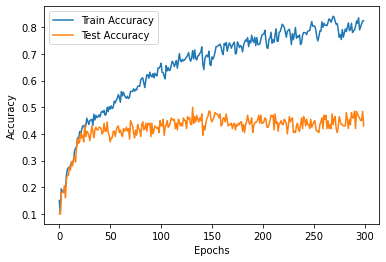

In [20]:
history = model.fit(X_tr,
          y_tr, 
          epochs=300,
          batch_size=40,
          validation_data=(X_t, y_t),
          verbose=False)

plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

train_loss, train_acc = model.evaluate(X_tr, y_tr)
test_loss, test_acc = model.evaluate(X_t, y_t)
print(train_acc)
print(test_acc)

# ***Aprendizaje no Supervisado***

## ***K-Means:***

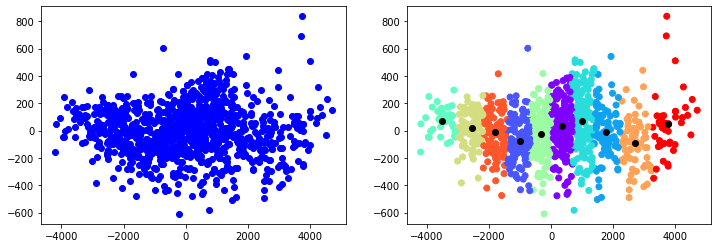

In [21]:
kmeans = KMeans(n_clusters=10)  
kmeans.fit(D)  

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(D[:,0], D[:,1], c="blue", cmap='rainbow');
plt.subplot(122) 
plt.scatter(D[:,0],D[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

## ***DBSCAN***:

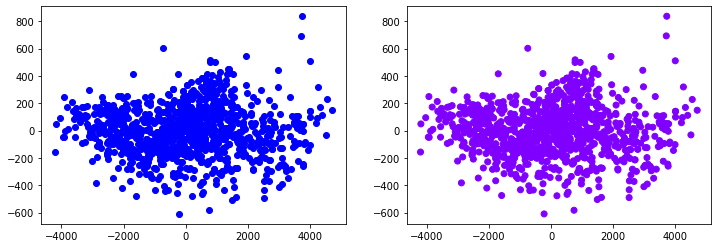

In [22]:
DBS = DBSCAN(eps=0.1)
DBS.fit(D) 

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(D[:,0], D[:,1], c="blue", cmap='rainbow');
plt.subplot(122) 
plt.scatter(D[:,0],D[:,1], c=DBS.labels_, cmap='rainbow');